In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'

import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from tqdm import tqdm_notebook
import datetime
import sys
%matplotlib inline  
from keras.preprocessing import image
from sklearn.model_selection import ShuffleSplit
import cv2
import time
from image import ImageDataGenerator


# get package versions
def get_version(*vars):
    for var in vars:
        module = __import__(var)    
        print ('%s: %s' %(var,module.__version__))
    
# package version    
get_version('keras','numpy','matplotlib','cv2')

Using Theano backend.


keras: 2.1.4
numpy: 1.14.3
matplotlib: 2.1.1
cv2: 3.4.1


Using cuDNN version 7004 on context None
Mapped name None to device cuda: GeForce GTX TITAN X (0000:02:00.0)


In [2]:
path2data="../data/"
path2train=path2data+"train/"
path2test=path2data+"test/"

norm_type="zeroMeanUnitStdPerSample"
im_height,im_width,im_chan=101,101,1
netinfo='trainTest2'
initialLearningRate=3e-4

In [3]:
# random data generator
datagen = ImageDataGenerator(featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.05,
        zoom_range=0.05,
        channel_shift_range=0.0,
        fill_mode='constant',
        cval=0.0,
        horizontal_flip=True,
        vertical_flip=True,)
        #data_format="channels_first") 

# calcualte dice
def calc_dice(X,Y,d=0):
    N=X.shape[d]    
    # intialize dice vector
    dice=np.zeros([N,1])

    for k in range(N):
        x=X[k,0] >.5 # convert to logical
        y =Y[k,0]>.5 # convert to logical

        # number of ones for intersection and union
        intersectXY=np.sum((x&y==1))
        unionXY=np.sum(x)+np.sum(y)

        if unionXY!=0:
            dice[k]=2* intersectXY/(unionXY*1.0)
            #print 'dice is: %0.2f' %dice[k]
        else:
            dice[k]=1
            #print 'dice is: %0.2f' % dice[k]
        #print 'processing %d, dice= %0.2f' %(k,dice[k])
    return np.mean(dice),dice    
    
def iterate_minibatches(inputs1 , targets,  batchsize, shuffle=True, augment=True):
    assert len(inputs1) == len(targets)
    if augment==True:
        if shuffle:
            indices = np.arange(len(inputs1))
            np.random.shuffle(indices)
        for start_idx in range(0, len(inputs1) - batchsize + 1, batchsize):
            if shuffle:
                excerpt = indices[start_idx:start_idx + batchsize]
            else:
                excerpt = slice(start_idx, start_idx + batchsize)
            x = inputs1[excerpt]
            y = targets[excerpt] 
            for  xxt,yyt in datagen.flow(x, y , batch_size=x.shape[0]):
                x = xxt.astype(np.float32) 
                y = yyt 
                break
    else:
        x=inputs1
        y=targets

    #yield np.array(x,np.uint8), np.array(y, dtype=np.uint8)         
    return np.array(x,np.uint8), np.array(y, dtype=np.uint8)     

# train test model
def train_test_model(X_train,y_train,X_test,y_test,params_train):
    foldnm=params_train['foldnm']  
    pre_train=params_train['pre_train'] 
    batch_size=params_train['batch_size'] 
    augmentation=params_train['augmentation'] 
    path2weights=params_train['path2weights'] 
    path2model=params_train['path2model'] 
    norm_type=params_train['norm_type'] 
    gamma=params_train['gamma'] 
    
    print('batch_size: %s, Augmentation: %s' %(batch_size,augmentation))
    
    print ('fold %s training in progress ...' %foldnm)
    # load last weights
    if pre_train== True:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print ('previous weights loaded!')
        else:
            raise IOError('weights does not exist!!!')
    else:
        if  os.path.exists(path2weights):
            model.load_weights(path2weights)
            print (path2weights)
            print ('previous weights loaded!')
            train_status='previous weights'
            return train_status
    
    # path to csv file to save scores
    path2scorescsv = weightfolder+'/scores.csv'
    first_row = 'train,test'
    with open(path2scorescsv, 'w+') as f:
        f.write(first_row + '\n')
           
    # Fit the model
    start_time=time.time()
    scores_test=[]
    scores_train=[]
    if params_train['loss']=='dice': 
        best_score = 0
        previous_score = 0
    else:
        best_score = 1e6
        previous_score = 1e6
    patience = 0
    
    # convert class vectors to binary class matrices
    
    
    for epoch in range(params_train['nbepoch']):
    
        print ('epoch: %s,  Current Learning Rate: %.1e' %(epoch,model.optimizer.lr.get_value()))
        #seed = np.random.randint(0, 999999)
    
        if augmentation:
            X_batch,Y_batch=iterate_minibatches(X_train,y_train,X_train.shape[0],shuffle=False,augment=True)  
            #X_batch=gammaAug(X_batch,gamma) # gamma/brightness augmentation
            #Y_batch=Y_batch[:,0][:,np.newaxis]
            #model.fit_generator(train_generator, steps_per_epoch=len(xtr)/batch_size, epochs=1,verbose=0)            
            hist=model.fit(preprocess(X_batch,norm_type), Y_batch, batch_size=batch_size,epochs=1, verbose=0)
        else:
            hist=model.fit(preprocess(X_train,norm_type), y_train, batch_size=batch_size,epochs=1, verbose=0)
            
        # evaluate on test and train data
        score_test=model.evaluate(preprocess(X_test,norm_type),y_test,verbose=0)
        score_train=np.mean(hist.history['loss'])
       
        print ('score_train: %s, score_test: %s' %(score_train,score_test))
        scores_test=np.append(scores_test,score_test)
        scores_train=np.append(scores_train,score_train)    

        # check for improvement    
        if (score_test<=best_score):
            print ("!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
            best_score = score_test
            patience = 0
            model.save_weights(path2weights)  
            model.save(path2model)
            
        # learning rate schedule
        if score_test>previous_score:
            #print "Incrementing Patience."
            patience += 1

        # learning rate schedule                
        if patience == params_train['max_patience']:
            params_train['learning_rate'] = params_train['learning_rate']/2
            print ("Upating Current Learning Rate to: ", params_train['learning_rate'])
            model.optimizer.lr.set_value(params_train['learning_rate'])
            print ("Loading the best weights again. best_score: ",best_score)
            model.load_weights(path2weights)
            patience = 0
        
        # save current test score
        previous_score = score_test    
        
        # store scores into csv file
        with open(path2scorescsv, 'a') as f:
            string = str([score_train,score_test])
            f.write(string + '\n')
           
    
    print ('model was trained!')
    elapsed_time=(time.time()-start_time)/60
    print ('elapsed time: %d  mins' %elapsed_time)      

    # train test progress plots
    plt.figure(figsize=(10,10))
    plt.plot(scores_test)
    plt.plot(scores_train)
    plt.title('train-validation progress',fontsize=20)
    plt.legend(('test','train'),fontsize=20)
    plt.xlabel('epochs',fontsize=20)
    plt.ylabel('loss',fontsize=20)
    plt.grid(True)
    plt.savefig(weightfolder+'/train_val_progress.png')
    plt.show()
    
    print ('training completed!')
    train_status='completed!'
    return train_status    

def preprocess(X,norm_type):    
    # type of normalization
    #norm_type=params['normalization_type']
    X=np.array(X,'float32')
    
    if norm_type =='zeroMeanUnitStd':
        for index in range(np.shape(X)[1]):
            meanX=np.mean(X[:,index,:,:])
            X[:,index] -= meanX
            stdX = np.std(X[:,index,:,:])
            if stdX!=0.0:
                X[:,index] /= stdX
    elif norm_type == 'zeroMeanUnitStdPerSample':
        for img_ind in range(np.shape(X)[0]):        
            for index in range(np.shape(X)[1]):
                meanX=np.mean(X[img_ind,index,:,:])
                stdX = np.std(X[img_ind,index,:,:])
                X[img_ind,index] -= meanX
                if stdX!=0.0:
                    X[img_ind,index] /= stdX
    elif norm_type == 'minus1_plus1': # [-1 to +1]
        X=np.array(X,'float32')
        X /= 255.
        X -= 0.5
        X *= 2.
    elif norm_type =='zeroMeanUnitStdGlobal':
        meanX=params['meanX'] # global mean
        stdX=params['stdX'] # global std
        for index in range(np.shape(X)[1]):
            X[:,index] -= meanX
            if stdX!=0.0:
                X[:,index] /= stdX
    elif norm_type == 'scale':
        X/=np.max(X)
    elif norm_type is None:
        pass
    else:
        raise IOError('no normalization was specified!')
    
    return X
def array_stats(X):
    X=np.asarray(X)
    print ('array shape: ',X.shape, X.dtype)
    #print 'min: %.3f, max:%.3f, avg: %.3f, std:%.3f' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print ('min: {}, max: {}, avg: {:.3}, std:{:.3}'.format( np.min(X),np.max(X),np.mean(X),np.std(X)))
    
def overlay_contour(img,mask):
    mask=np.array(mask,"uint8")
    im2, contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (0,255,0), 3)
    return img    
def disp_imgs_masks(X,Y,r=2,c=3):
    assert np.ndim(X)==np.ndim(Y)        
    n=r*c
    plt.figure(figsize=(12,8))
    indices=np.random.randint(len(X),size=n)
    for k,ind in enumerate(indices):
        img=X[ind,0]
        mask=Y[ind,0]
        img=overlay_contour(img,mask)    
        plt.subplot(r,c,k+1)
        plt.imshow(img,cmap="gray");        
        plt.title(ind)    

        

In [4]:
df_depths = pd.read_csv(path2data+'depths.csv', index_col='id')
df_depths.head()

,z
id,
4ac19fb269,306
1825fadf99,157
f59821d067,305
5b435fad9d,503
e340e7bfca,783


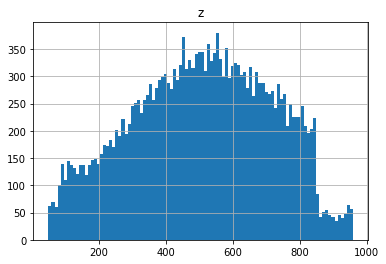

In [5]:
df_depths.hist(bins=100);

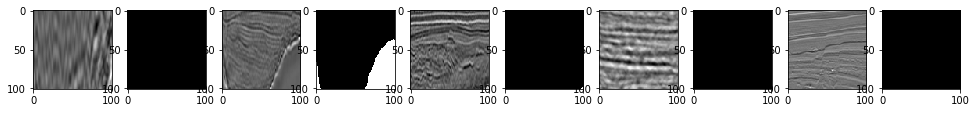

In [6]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = image.load_img(path2train+"/images/" + img_name + '.png')
    img_mask = image.load_img(path2train+"/masks/" + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [7]:
train_ids = next(os.walk(path2train+"images"))[2]
test_ids = next(os.walk(path2test+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_chan,im_height, im_width ), dtype=np.uint8)
Y = np.zeros((len(train_ids), 1,im_height, im_width), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path2train
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[0]
    X[n] = x
    mask = image.img_to_array(image.load_img(path + '/masks/' + id_))[0]
    Y[n] = mask

print('Done!')


Getting and resizing train images and masks ... 


HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))


Done!


In [8]:
array_stats(X)
array_stats(Y)

array shape:  (4000, 1, 101, 101) uint8
min: 0, max: 255, avg: 1.2e+02, std:41.1
array shape:  (4000, 1, 101, 101) bool
min: False, max: True, avg: 0.248, std:0.432


In [9]:
numOfNonzeroMasks=np.count_nonzero(np.any(Y,axis=(2,3)))
print("number of nonzero masks: %s" %numOfNonzeroMasks)

number of nonzero masks: 2438


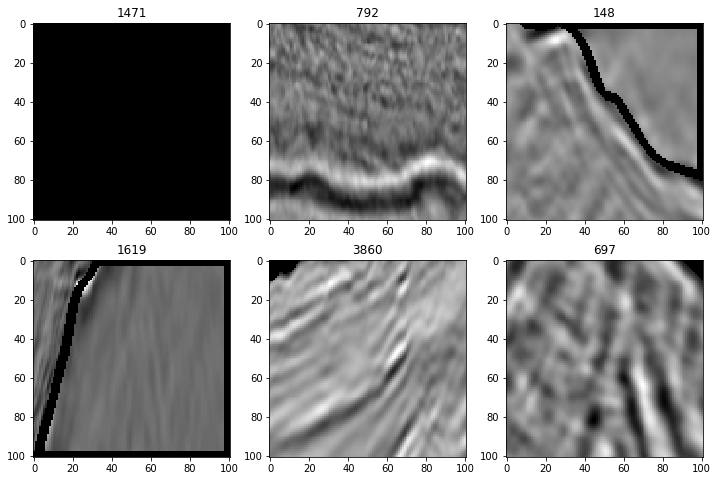

In [10]:
disp_imgs_masks(X,Y)

In [11]:
from keras.layers import Input, merge, Convolution2D, Deconvolution2D, AtrousConvolution2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Dense
from keras.layers.core import Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import layer_utils
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose
from keras.layers import Concatenate
from keras.layers import AtrousConv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Dense
from keras.layers.core import Activation
from keras.layers import Activation,Reshape,Permute
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.utils import layer_utils
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU,PReLU,LeakyReLU
from keras.regularizers import l2
from keras.layers import ZeroPadding2D
from keras.layers import Cropping2D

def conv2dcustom(x_input,filters=8,kernel_size=3,strides=1,w2reg=None,pool=False,padding='same',batchNorm=False,activation='relu'):
    data_format='channels_first'
    x1 = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding,data_format=data_format,kernel_regularizer=w2reg,strides=strides)(x_input)
    if batchNorm==True:
        x1=BatchNormalization(axis=1)(x1)
        
    if activation=='leaky':        
        x1 = LeakyReLU(0.1)(x1)
    else:
        conv1=Activation('relu')(conv1)        

    if pool==True:
        x1=MaxPooling2D(pool_size=(2, 2),data_format=data_format)(x1)
    
    return x1


# model
def model_skip(params):

    h=params['h']
    w=params['w']
    z=params['z']
    lr=params['learning_rate']
    loss=params['loss']
    C=params['initial_channels']
    nb_output=params['num_labels']
    dropout_rate=params['dropout_rate']
    data_format='channels_first'
    batchNorm=params['batchNorm']
    w2reg=params['w2reg']
    initStride=params['initStride']
    reshape4softmax=params['reshape4softmax']
    
    
    inputs = Input((z,h, w))
    inputsPadded=ZeroPadding2D(padding=((13,14), (13,14)),data_format="channels_first")(inputs)
    conv1=conv2dcustom(filters=C,x_input=inputsPadded,strides=initStride,w2reg=w2reg,activation='leaky')    
    pool1=conv2dcustom(filters=C,x_input=conv1,w2reg=w2reg,pool=True,activation='leaky')    

    conv2=conv2dcustom(filters=2*C,x_input=pool1,w2reg=w2reg,activation='leaky')    
    pool2=conv2dcustom(filters=2*C,x_input=conv2,w2reg=w2reg,pool=True,activation='leaky')    
    
    conv3=conv2dcustom(filters=4*C,x_input=pool2,w2reg=w2reg,activation='leaky')    
    pool3=conv2dcustom(filters=4*C,x_input=conv3,w2reg=w2reg,pool=True,activation='leaky')    

    conv4=conv2dcustom(filters=8*C,x_input=pool3,w2reg=w2reg,activation='leaky')    
    pool4=conv2dcustom(filters=8*C,x_input=conv4,w2reg=w2reg,pool=True,activation='leaky')    

    conv5=conv2dcustom(filters=16*C,x_input=pool4,w2reg=w2reg,activation='leaky')    
    conv5=conv2dcustom(filters=16*C,x_input=conv5,w2reg=w2reg,pool=False,activation='leaky')    
    
    # dropout
    conv5 =Dropout(dropout_rate)(conv5)
    
    up7=UpSampling2D(size=(2, 2),data_format=data_format)(conv5)
    concat = Concatenate(axis=1)
    up7 = concat([up7, conv4])

    conv7=conv2dcustom(filters=8*C,x_input=up7,w2reg=w2reg,pool=False,activation='leaky')    
    
    up8 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv7), conv3])

    conv8=conv2dcustom(filters=4*C,x_input=up8,w2reg=w2reg,pool=False,activation='leaky')        
    
    up9 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv8), conv2])
    
    conv9=conv2dcustom(filters=2*C,x_input=up9,w2reg=w2reg,pool=False,activation='leaky')        

    up10 = concat([UpSampling2D(size=(2, 2),data_format=data_format)(conv9), conv1])
    conv10=conv2dcustom(filters=C,x_input=up10,w2reg=w2reg,pool=False,activation='leaky')        

    conv10 = UpSampling2D(size=(initStride, initStride),data_format=data_format)(conv10)
    conv10=conv2dcustom(filters=C,x_input=conv10,w2reg=w2reg,pool=False,activation='leaky')        
    
    conv10 = Conv2D(nb_output, 1, data_format=data_format,kernel_regularizer=w2reg)(conv10)
    conv10=Cropping2D(cropping=((13,14),(13,14)),data_format="channels_first")(conv10)

    if reshape4softmax:
        # reshape for softmax
        output=Reshape((nb_output,h*w)) (conv10)
        # permute for softmax
        output=Permute((2,1))(output)
        # softmax
        output=Activation('softmax')(output)
    else:        
        output=Activation('sigmoid')(conv10)
    
    model = Model(inputs=inputs, outputs=output)

    if loss=='dice':
        model.compile(optimizer=Adam(lr), loss=dice_coef_loss, metrics=[dice_coef])
    else:
        #model.compile(loss='binary_crossentropy', optimizer=Adam(lr))
        model.compile(loss=loss, optimizer=Adam(lr))
    
    return model

In [12]:
n,z,h,w=X.shape

params_train={
    'h': h,
    'w': w,
    'z':z,
    'learning_rate': 3e-4,
    'optimizer': 'Adam',
    #'loss': 'categorical_crossentropy',
    'loss': 'binary_crossentropy',
    'nbepoch': 400 ,
    'num_labels': 1,
    'initial_channels':16,
    'dropout_rate': 0.5,
    'max_patience': 30,
    'experiment': None,
    'pre_train': False,
    'elastic_arg': None,
    'trainaug_params': None,
    'batch_size': 8,
    'weightfolder': None,
    'w2reg': None, #l2(1e-4),    
    'batchNorm': False,
    'initStride': 1,
    'norm_type': norm_type,
    'augmentation': True,
    'reshape4softmax': False,
    'gamma': 0.3,
    }
    
model = model_skip(params_train)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 101, 101)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 1, 128, 128)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 128, 128) 160         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 128, 128) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

conv2d_16 (Conv2D)              (None, 1, 128, 128)  17          leaky_re_lu_15[0][0]             
__________________________________________________________________________________________________
cropping2d_1 (Cropping2D)       (None, 1, 101, 101)  0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 1, 101, 101)  0           cropping2d_1[0][0]               
Total params: 1,768,577
Trainable params: 1,768,577
Non-trainable params: 0
__________________________________________________________________________________________________


wait ...
array shape:  (3200, 1, 101, 101) uint8
min: 0, max: 255, avg: 1.2e+02, std:41.3
array shape:  (3200, 1, 101, 101) uint8
min: 0, max: 1, avg: 0.249, std:0.432
array shape:  (800, 1, 101, 101) uint8
min: 0, max: 255, avg: 1.21e+02, std:40.3
array shape:  (800, 1, 101, 101) uint8
min: 0, max: 1, avg: 0.243, std:0.429
------------------------------
experiment: trainTest2_hw_101by101_initfilts_16
weights folder created
batch_size: 8, Augmentation: True
fold 1 training in progress ...
epoch: 0,  Current Learning Rate: 3.0e-04
score_train: 0.41884167386218907, score_test: 0.4523561358451843
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 1,  Current Learning Rate: 3.0e-04
score_train: 0.32170282760635016, score_test: 0.40093367755413056
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, improvement!!!!!!!!!!!!!!!!!!!!!!!!!!!
epoch: 2,  Current Learning Rate: 3.0e-04
score_train: 0.2903608182258904, score_test: 0.32357145607471466
!!!!!!!!!!!!!!!!!!!!!!!!!!! viva, impr

score_train: 0.12366319076623768, score_test: 0.21005602329969406
epoch: 61,  Current Learning Rate: 3.0e-04
score_train: 0.12262969525530934, score_test: 0.18773915350437165
epoch: 62,  Current Learning Rate: 3.0e-04
score_train: 0.12407717420021072, score_test: 0.21451111644506454
epoch: 63,  Current Learning Rate: 3.0e-04
score_train: 0.11716262931236997, score_test: 0.17912792921066284
epoch: 64,  Current Learning Rate: 3.0e-04
score_train: 0.14669365366455167, score_test: 0.17751969367265702
epoch: 65,  Current Learning Rate: 3.0e-04
score_train: 0.12234237823169679, score_test: 0.1739954701066017
epoch: 66,  Current Learning Rate: 3.0e-04
score_train: 0.11975025326712058, score_test: 0.17533760219812394
epoch: 67,  Current Learning Rate: 3.0e-04
score_train: 0.11456924617290497, score_test: 0.16639379054307937
epoch: 68,  Current Learning Rate: 3.0e-04
score_train: 0.1182115777861327, score_test: 0.16900311440229415
epoch: 69,  Current Learning Rate: 3.0e-04
score_train: 0.114480

score_train: 0.08383271249127575, score_test: 0.1850979933142662
epoch: 136,  Current Learning Rate: 3.0e-04
score_train: 0.07788020718377084, score_test: 0.2367781290411949
epoch: 137,  Current Learning Rate: 3.0e-04
score_train: 0.07844502977415686, score_test: 0.20690444022417068
epoch: 138,  Current Learning Rate: 3.0e-04
score_train: 0.07852650512941181, score_test: 0.1778144958615303
epoch: 139,  Current Learning Rate: 3.0e-04
score_train: 0.07786634670104832, score_test: 0.1586012890934944
epoch: 140,  Current Learning Rate: 3.0e-04
score_train: 0.08150174499256536, score_test: 0.1887027780711651
epoch: 141,  Current Learning Rate: 3.0e-04
score_train: 0.07650697935605422, score_test: 0.2560228660702705
epoch: 142,  Current Learning Rate: 3.0e-04
score_train: 0.08505745218019001, score_test: 0.16394417941570283
epoch: 143,  Current Learning Rate: 3.0e-04
score_train: 0.07448514899704606, score_test: 0.2071940141916275
epoch: 144,  Current Learning Rate: 3.0e-04
score_train: 0.08

score_train: 0.059953242962947115, score_test: 0.23070695847272873
epoch: 210,  Current Learning Rate: 1.5e-04
score_train: 0.05963221634738147, score_test: 0.24095250084996223
epoch: 211,  Current Learning Rate: 1.5e-04
score_train: 0.05993446020176634, score_test: 0.21244315892457963
epoch: 212,  Current Learning Rate: 1.5e-04
score_train: 0.060097058311803266, score_test: 0.18781500428915024
epoch: 213,  Current Learning Rate: 1.5e-04
score_train: 0.0577906080102548, score_test: 0.23889080554246903
epoch: 214,  Current Learning Rate: 1.5e-04
score_train: 0.05907491988036782, score_test: 0.19636594042181968
epoch: 215,  Current Learning Rate: 1.5e-04
score_train: 0.05586642323061824, score_test: 0.2079532624781132
epoch: 216,  Current Learning Rate: 1.5e-04
score_train: 0.05644691883237101, score_test: 0.18871674090623855
epoch: 217,  Current Learning Rate: 1.5e-04
score_train: 0.059312458910280835, score_test: 0.2109771513938904
epoch: 218,  Current Learning Rate: 1.5e-04
score_trai

score_train: 0.05032928795204498, score_test: 0.21471226066350937
epoch: 284,  Current Learning Rate: 7.5e-05
score_train: 0.04806949453690322, score_test: 0.20373804688453676
epoch: 285,  Current Learning Rate: 7.5e-05
score_train: 0.048646095743170005, score_test: 0.2156449382007122
epoch: 286,  Current Learning Rate: 7.5e-05
score_train: 0.05265764362644404, score_test: 0.1930907227098942
epoch: 287,  Current Learning Rate: 7.5e-05
score_train: 0.050073805598076435, score_test: 0.20855340287089347
Upating Current Learning Rate to:  3.75e-05
Loading the best weights again. best_score:  0.14970719635486604
epoch: 288,  Current Learning Rate: 3.8e-05
score_train: 0.07085533701465466, score_test: 0.1679364413022995
epoch: 289,  Current Learning Rate: 3.8e-05
score_train: 0.06768529191147536, score_test: 0.17837601959705351
epoch: 290,  Current Learning Rate: 3.8e-05
score_train: 0.06613911237567663, score_test: 0.18069232106208802
epoch: 291,  Current Learning Rate: 3.8e-05
score_train:

score_train: 0.05977624472579919, score_test: 0.17981986299157143
epoch: 357,  Current Learning Rate: 1.9e-05
score_train: 0.057209662557579574, score_test: 0.18518329694867133
epoch: 358,  Current Learning Rate: 1.9e-05
score_train: 0.060911218771943824, score_test: 0.18597122624516488
epoch: 359,  Current Learning Rate: 1.9e-05
score_train: 0.05921123961918056, score_test: 0.17763644590973854
epoch: 360,  Current Learning Rate: 1.9e-05
score_train: 0.06116623130219523, score_test: 0.17482177183032035
epoch: 361,  Current Learning Rate: 1.9e-05
score_train: 0.059431010448606686, score_test: 0.17310360044240952
epoch: 362,  Current Learning Rate: 1.9e-05
score_train: 0.05793728607124649, score_test: 0.18389373734593392
epoch: 363,  Current Learning Rate: 1.9e-05
score_train: 0.0601637629896868, score_test: 0.1849166151881218
epoch: 364,  Current Learning Rate: 1.9e-05
score_train: 0.05795393213396892, score_test: 0.19152844116091727
epoch: 365,  Current Learning Rate: 1.9e-05
score_tra

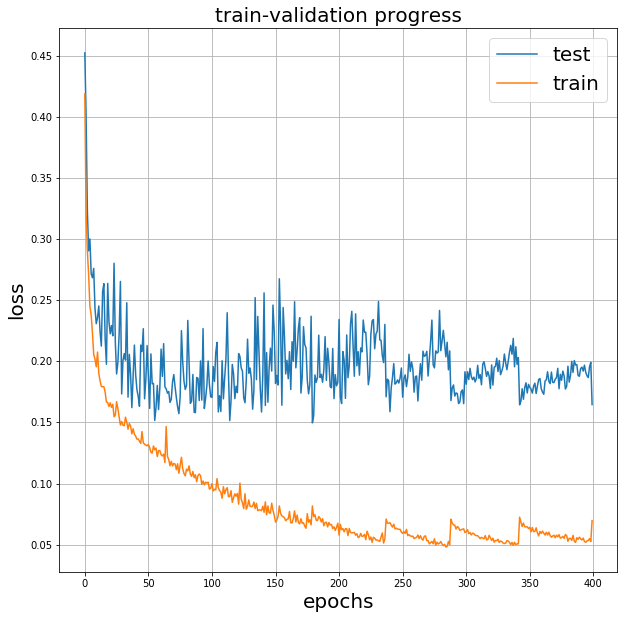

training completed!
weights loaded!
score_test: 0.14971
average dice: 0.78
------------------------------
average score for 1 folds is 0.14970719579607247


In [13]:
n_folds=1
skf = ShuffleSplit(n_splits=n_folds, test_size=0.2, random_state=321)

# loop over folds
foldnm=0
scores_nfolds=[]

print ('wait ...')
for train_ind, test_ind in skf.split(X,Y):
    foldnm+=1    

    train_ind=list(np.sort(train_ind))
    test_ind=list(np.sort(test_ind))
    
    X_train,Y_train=X[train_ind],np.array(Y[train_ind],'uint8')
    X_test,Y_test=X[test_ind],np.array(Y[test_ind],'uint8')
    
    array_stats(X_train)
    array_stats(Y_train)
    array_stats(X_test)
    array_stats(Y_test)
    print ('-'*30)

    # exeriment name to record weights and scores
    experiment=netinfo+'_hw_'+str(h)+'by'+str(w)+'_initfilts_'+str(params_train['initial_channels'])
    print ('experiment:', experiment)

    weightfolder='./output/weights/'+experiment+'/fold'+str(foldnm)
    if  not os.path.exists(weightfolder):
        os.makedirs(weightfolder)
        print ('weights folder created')    
    
    # path to weights
    path2weights=weightfolder+"/weights.hdf5"
    path2model=weightfolder+"/model.hdf5"    
    
    # train test on fold #
    params_train['foldnm']=foldnm
    params_train['learning_rate']=initialLearningRate
    params_train['path2weights']=path2weights
    params_train['path2model']=path2model
    model=model_skip(params_train)
    #model.summary()    
    train_test_model(X_train,Y_train,X_test,Y_test,params_train)
    
    # loading best weights from training session
    if  os.path.exists(path2weights):
        model.load_weights(path2weights)
        print ('weights loaded!')
    else:
        raise IOError('weights does not exist!!!')
    
    score_test=model.evaluate(preprocess(X_test,norm_type),Y_test,verbose=0,batch_size=8)
    print ('score_test: %.5f' %(score_test))    
    Y_pred=model.predict(preprocess(X_test,norm_type))>0.5
    dicePerFold,_=calc_dice(Y_test,Y_pred)
    print('average dice: %.2f' %dicePerFold)
    print ('-' *30)
    # store scores for all folds
    scores_nfolds.append(score_test)

print ('average score for %s folds is %s' %(n_folds,np.mean(scores_nfolds)))

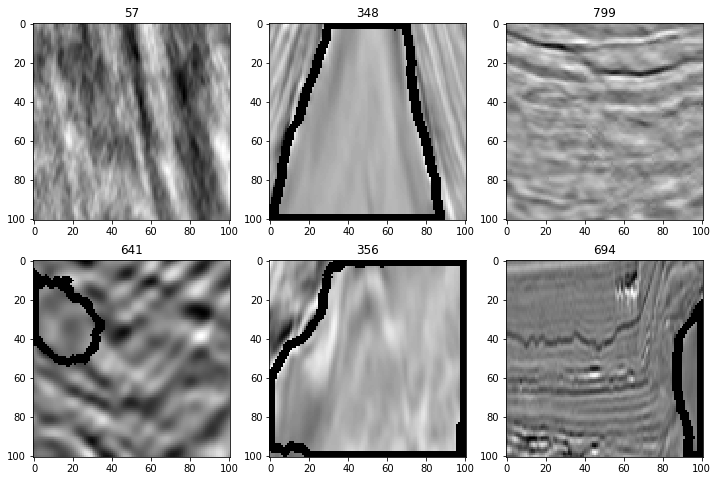

In [14]:
disp_imgs_masks(X_test,Y_pred)

In [15]:
# Get and resize train images and masks
X_leaderboard = np.zeros((len(test_ids), im_chan,im_height, im_width ), dtype=np.uint8)

sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path2test
    img = image.load_img(path + '/images/' + id_)
    x = image.img_to_array(img)[0]
    X_leaderboard[n] = x

print('Done!')

HBox(children=(IntProgress(value=0, max=18000), HTML(value='')))


Done!


In [16]:
Y_leaderboard=model.predict(preprocess(X_leaderboard,norm_type))>0.5

In [17]:
array_stats(X_leaderboard)
array_stats(Y_leaderboard)

array shape:  (18000, 1, 101, 101) uint8
min: 0, max: 255, avg: 1.2e+02, std:41.7
array shape:  (18000, 1, 101, 101) bool
min: False, max: True, avg: 0.239, std:0.426


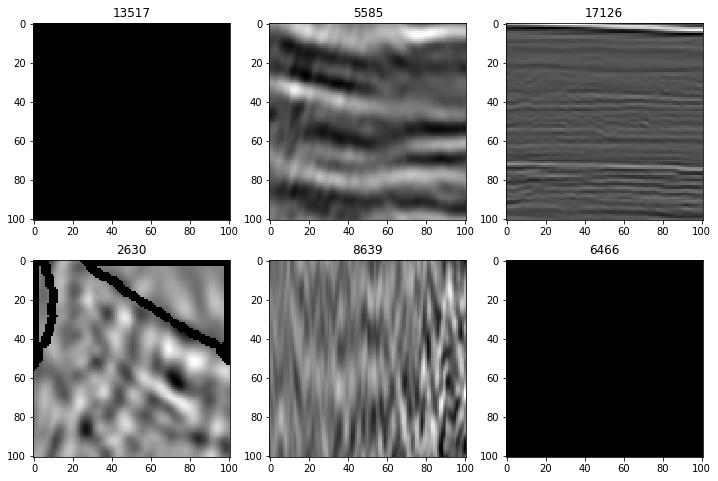

In [18]:
disp_imgs_masks(X_leaderboard,Y_leaderboard)

In [19]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(Y_leaderboard[i,0])) for i,fn in enumerate(test_ids)}

In [20]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']

In [21]:
# Create submission DataFrame
now = datetime.datetime.now()
info=experiment
suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
submissionFolder='./output/submissions'
if not os.path.exists(submissionFolder):
    os.mkdir(submissionFolder)
    print(submissionFolder+ ' created!')
path2submission = os.path.join(submissionFolder, 'submission_' + suffix + '.csv')
print(path2submission)
sub.to_csv(path2submission)
sub.head()

./output/submissions/submission_trainTest2_hw_101by101_initfilts_16_2018-07-24-02-46.csv


,rle_mask
id,
0005bb9630,371 25 399 6 471 26 500 6 569 2 572 11 584 13 ...
000a68e46c,
000c8dfb2a,
000d0a5f6c,
001ef8fc87,1 7171 7173 95 7274 84 7374 76 7475 71 7576 62...
